In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score, classification_report,
    roc_curve, precision_recall_curve, auc
)

# 1. Load Data
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/data_ecommerce_customer_churn.csv"
df = pd.read_csv(url)

# 2. Preprocessing
X = df.drop('Churn', axis=1)
y = df['Churn']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Global list to store comparison results
model_comparison = []

# 4. Helper Function for Visualization and Metrics
def evaluate_and_visualize(model, model_name, X_test, y_test):
    # Predict labels and probabilities
    y_pred = model.predict(X_test)

    # Check if model has predict_proba (most do), else use decision_function
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        # Normalize decision function for ROC/PR if needed, but usually probability=True for SVC solves this.

    # --- Metrics Calculation ---
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred) # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f} | F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Store metrics for final comparison
    model_comparison.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_Score": f1,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc
    })

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} - ROC Curve')
    axes[1].legend(loc="lower right")

    # 3. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    axes[2].plot(recall_curve, precision_curve, label=f'PR AUC = {pr_auc:.2f}', color='green', lw=2)
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title(f'{model_name} - Precision-Recall Curve')
    axes[2].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

print("Setup Complete. Ready to train models.")

Setup Complete. Ready to train models.


--- K-Nearest Neighbour Evaluation ---
Accuracy: 0.8859 | Precision: 0.7600 | Recall (Sensitivity): 0.4419
Specificity: 0.9727 | F1 Score: 0.5588
ROC AUC: 0.9123 | PR AUC: 0.6237

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       660
           1       0.76      0.44      0.56       129

    accuracy                           0.89       789
   macro avg       0.83      0.71      0.75       789
weighted avg       0.88      0.89      0.87       789



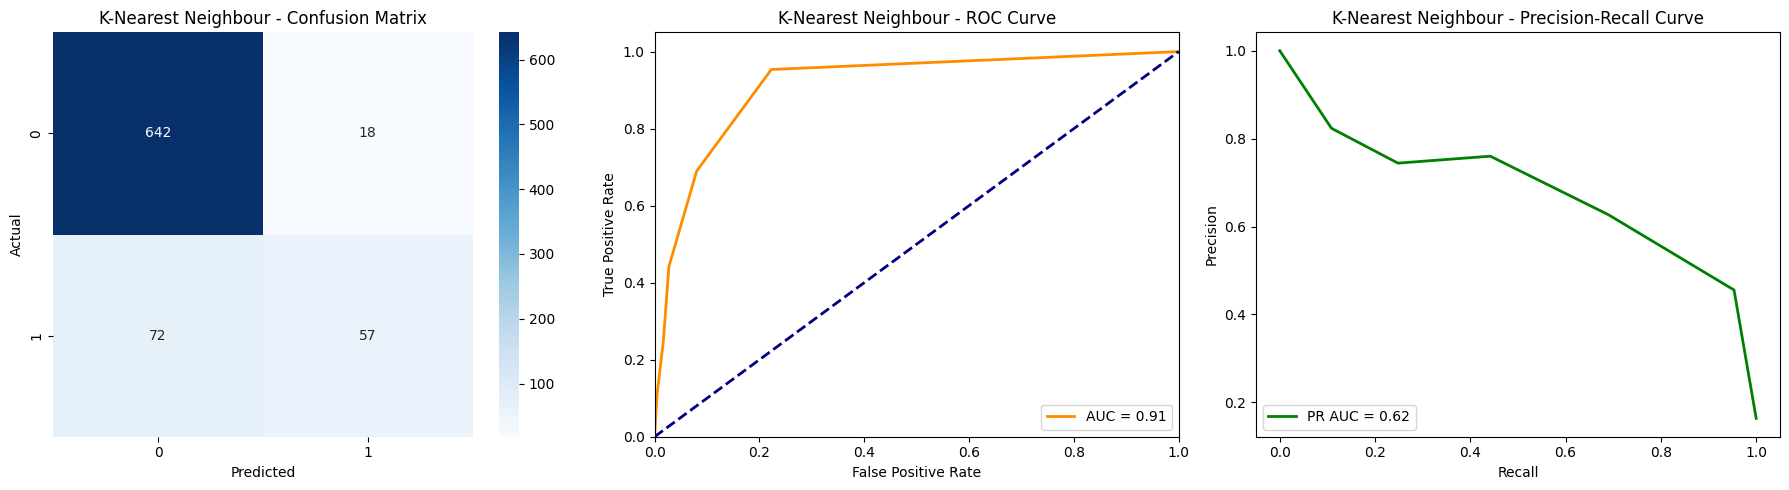

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier(n_neighbors=5))])

# Train
knn_model.fit(X_train, y_train)

# Visual Evaluation
evaluate_and_visualize(knn_model, "K-Nearest Neighbour", X_test, y_test)

--- Logistic Regression Evaluation ---
Accuracy: 0.8935 | Precision: 0.7711 | Recall (Sensitivity): 0.4961
Specificity: 0.9712 | F1 Score: 0.6038
ROC AUC: 0.8868 | PR AUC: 0.6797

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       660
           1       0.77      0.50      0.60       129

    accuracy                           0.89       789
   macro avg       0.84      0.73      0.77       789
weighted avg       0.89      0.89      0.88       789



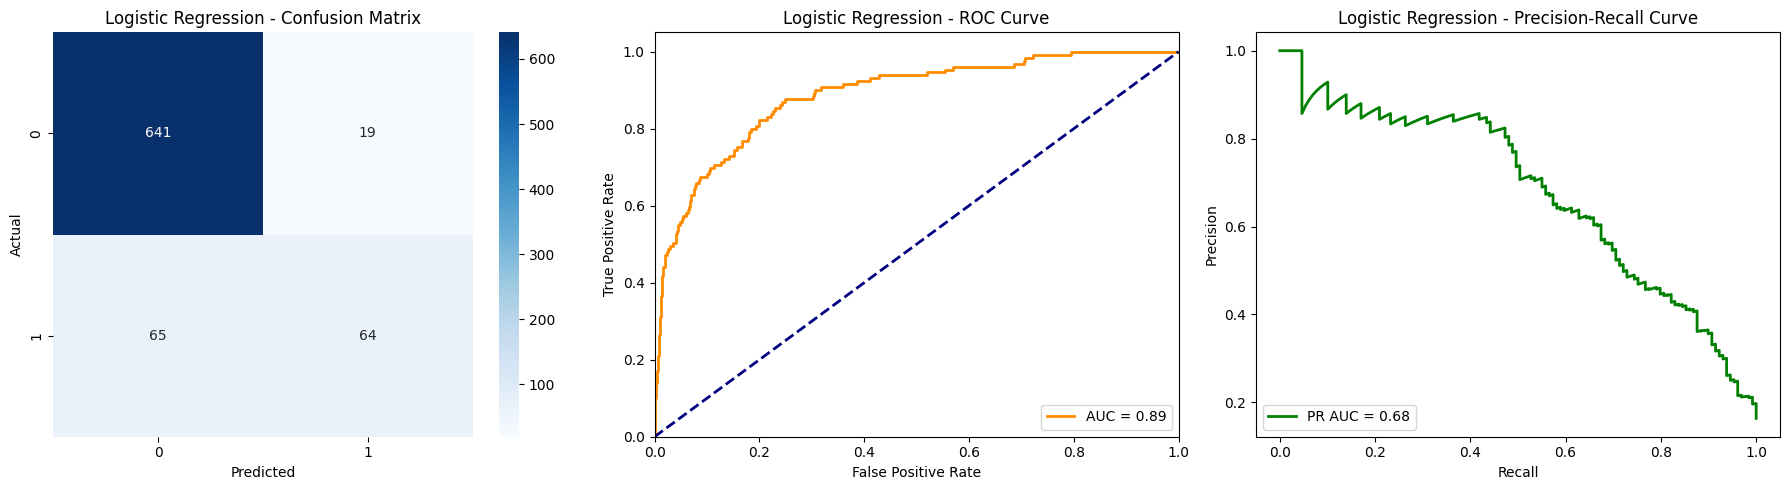

In [7]:
from sklearn.linear_model import LogisticRegression

# Pipeline
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# Train
lr_model.fit(X_train, y_train)

# Visual Evaluation
evaluate_and_visualize(lr_model, "Logistic Regression", X_test, y_test)

--- Decision Trees Evaluation ---
Accuracy: 0.9138 | Precision: 0.7293 | Recall (Sensitivity): 0.7519
Specificity: 0.9455 | F1 Score: 0.7405
ROC AUC: 0.8487 | PR AUC: 0.5890

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       660
           1       0.73      0.75      0.74       129

    accuracy                           0.91       789
   macro avg       0.84      0.85      0.84       789
weighted avg       0.91      0.91      0.91       789



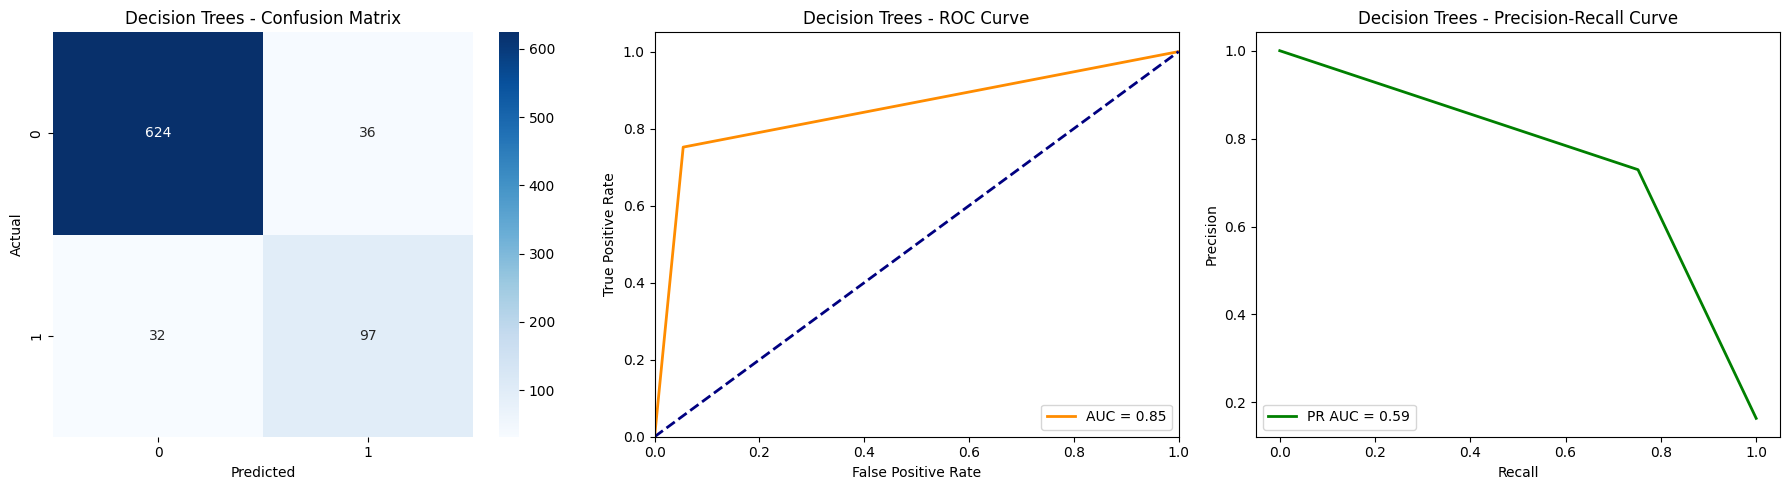

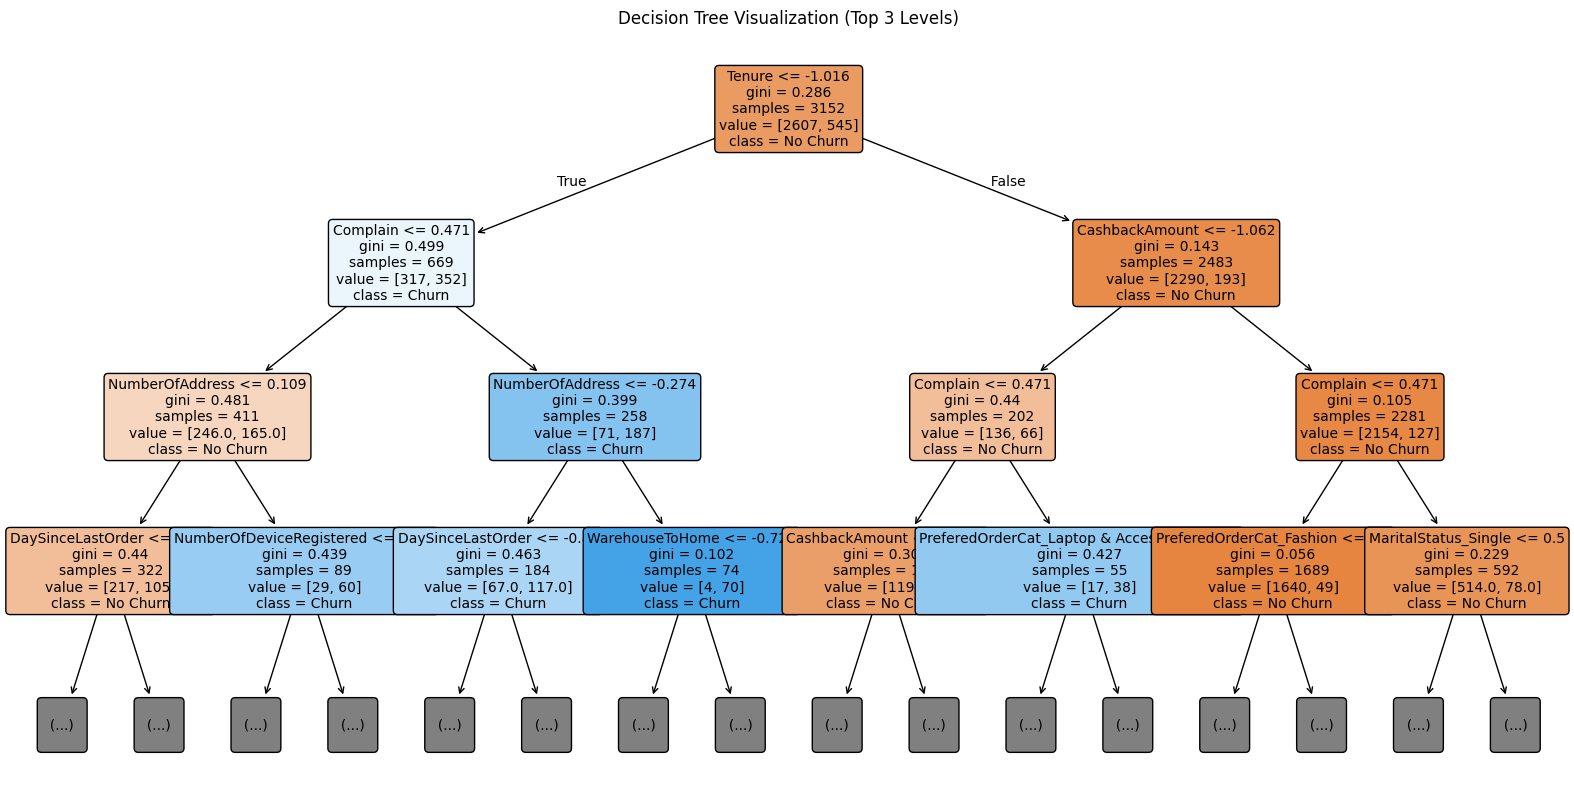

In [8]:
# IMPORTANT: Ensure the setup cell (G2IL0gtyT5X_) is run before this cell.
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline # Added this import

# Pipeline
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=42))])

# Train
dt_model.fit(X_train, y_train)

# Visual Evaluation
evaluate_and_visualize(dt_model, "Decision Trees", X_test, y_test)

# --- Tree Visualization ---
# 1. Extract feature names from the preprocessor
feature_names = dt_model.named_steps['preprocessor'].get_feature_names_out()
# Clean up names (remove 'num__' and 'cat__' prefixes if present)
feature_names_clean = [f.split('__')[-1] for f in feature_names]

# 2. Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model.named_steps['classifier'],
          feature_names=feature_names_clean,
          class_names=['No Churn', 'Churn'],
          filled=True,
          rounded=True,
          max_depth=3,  # Top 3 levels for readability
          fontsize=10)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

--- Support Vector Machines Evaluation ---
Accuracy: 0.8973 | Precision: 0.8429 | Recall (Sensitivity): 0.4574
Specificity: 0.9833 | F1 Score: 0.5930
ROC AUC: 0.9169 | PR AUC: 0.7293

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       660
           1       0.84      0.46      0.59       129

    accuracy                           0.90       789
   macro avg       0.87      0.72      0.77       789
weighted avg       0.89      0.90      0.88       789



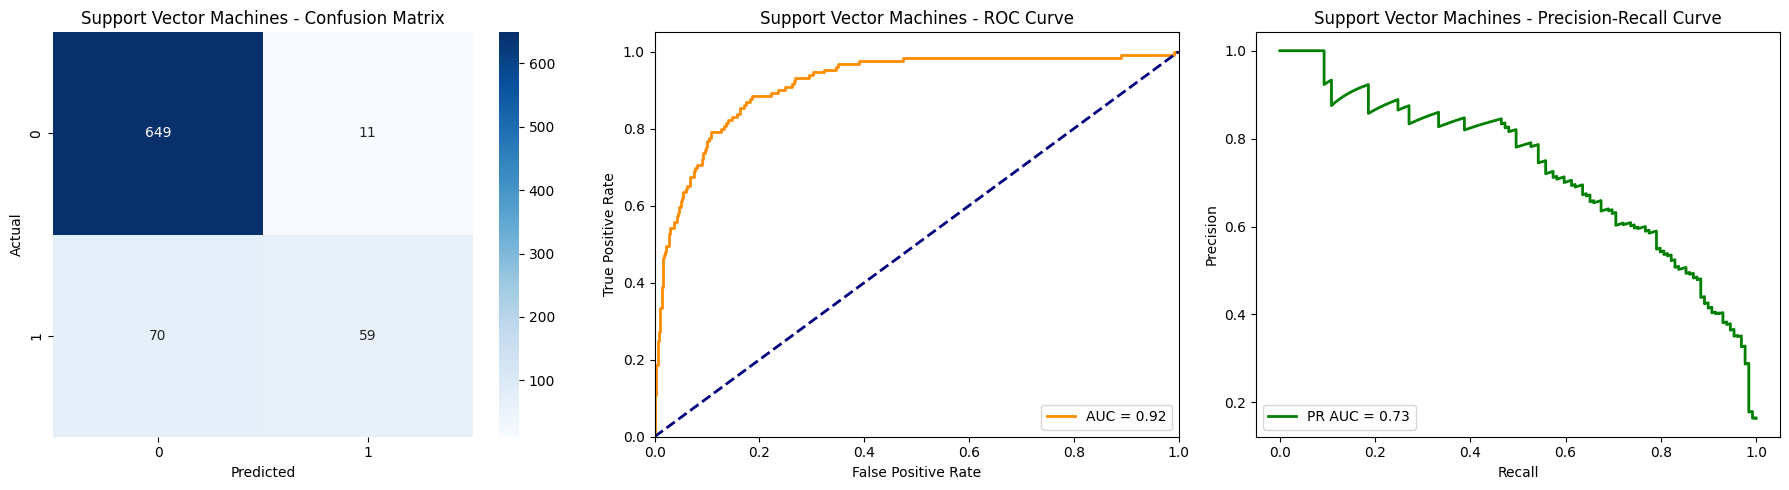

In [9]:
from sklearn.svm import SVC

# Pipeline
# probability=True is required for ROC/AUC calculation in SVM
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(probability=True, random_state=42))])

# Train
svm_model.fit(X_train, y_train)

# Visual Evaluation
evaluate_and_visualize(svm_model, "Support Vector Machines", X_test, y_test)

--- Naive Bayes Evaluation ---
Accuracy: 0.7427 | Precision: 0.3555 | Recall (Sensitivity): 0.7054
Specificity: 0.7500 | F1 Score: 0.4727
ROC AUC: 0.8066 | PR AUC: 0.5018

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       660
           1       0.36      0.71      0.47       129

    accuracy                           0.74       789
   macro avg       0.64      0.73      0.65       789
weighted avg       0.83      0.74      0.77       789



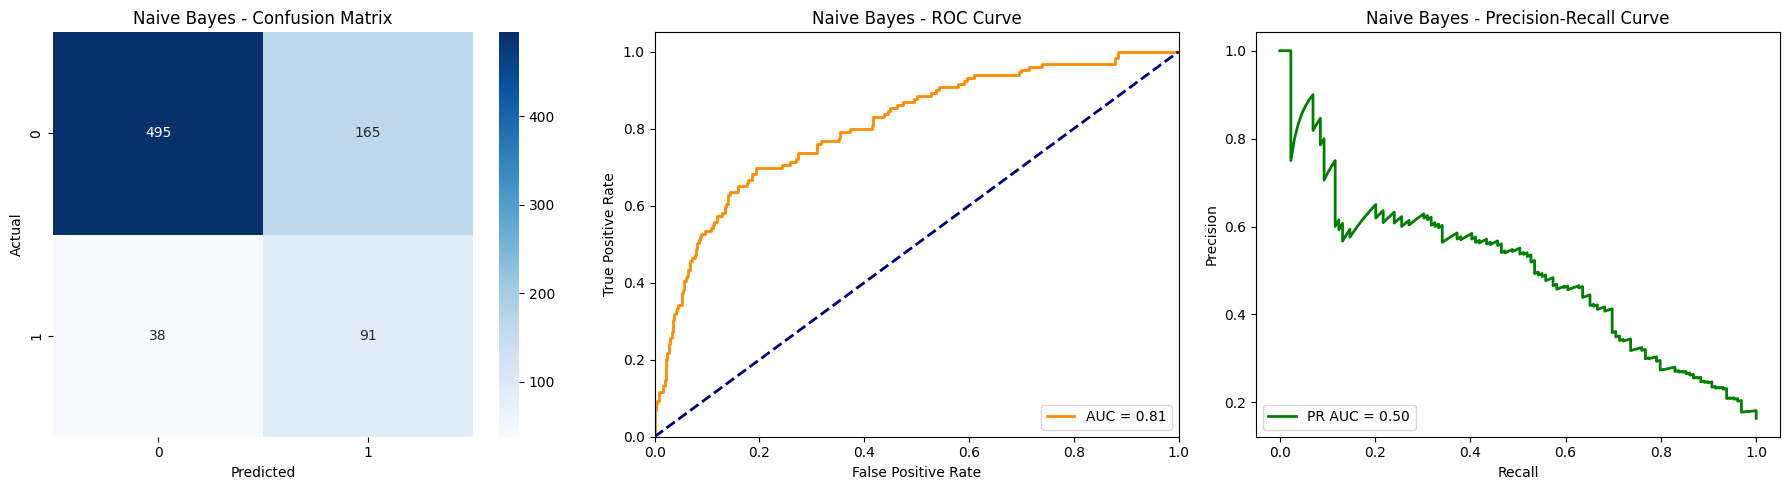

In [10]:
from sklearn.naive_bayes import GaussianNB

# Pipeline
nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GaussianNB())])

# Train
nb_model.fit(X_train, y_train)

# Visual Evaluation
evaluate_and_visualize(nb_model, "Naive Bayes", X_test, y_test)

Final Cross-Model Comparison:


,Model,Accuracy,Precision,Recall,Specificity,F1_Score,ROC_AUC,PR_AUC
2,Decision Trees,0.913815,0.729323,0.751938,0.945455,0.740458,0.848696,0.588964
1,Logistic Regression,0.893536,0.771084,0.496124,0.971212,0.603774,0.886833,0.679704
3,Support Vector Machines,0.897338,0.842857,0.457364,0.983333,0.592965,0.916937,0.729258
0,K-Nearest Neighbour,0.885932,0.760000,0.441860,0.972727,0.558824,0.912303,0.623651
4,Naive Bayes,0.742712,0.355469,0.705426,0.750000,0.472727,0.806577,0.501778


/tmp/ipython-input-2609222571.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1_Score', y='Model', data=results_df, palette='viridis')


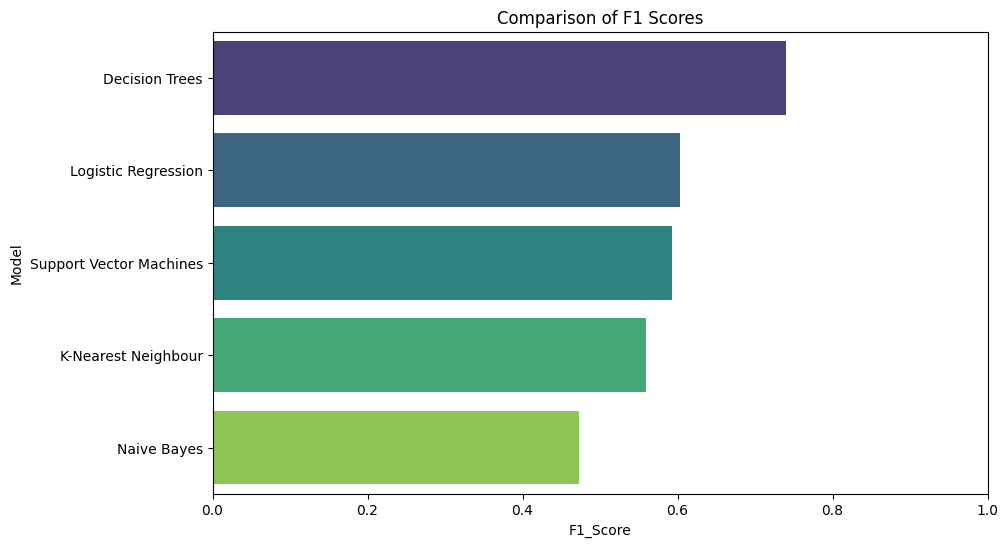

In [11]:
# Create Comparison DataFrame
results_df = pd.DataFrame(model_comparison)

# Sort by F1 Score (or Accuracy) to see best performers
results_df = results_df.sort_values(by='F1_Score', ascending=False)

# Display
print("Final Cross-Model Comparison:")
# Styling the dataframe for better readability if using Jupyter
try:
    display(results_df.style.background_gradient(cmap='Greens'))
except:
    print(results_df)

# Optional: Bar chart for F1 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='F1_Score', y='Model', data=results_df, palette='viridis')
plt.title('Comparison of F1 Scores')
plt.xlim(0, 1)
plt.show()